In [2]:
from Crypto.Random import random
from tqdm.notebook import tqdm

# Prerequisites

- LFSR
- PRNG

# Theory

Another way to generate PRNGs with some kind of weak security is constructing nonlinear relations from different outputs of LFSRs

One such generator is the **Geffe LFSR**

We'll look at how it's constructed and a way to break it

## Construction

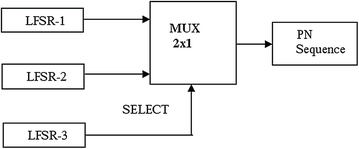

We use 3 LFSRs
- they clock simultaneously
- One decides if the output which of the other 2 LFSRs should output

|b_0|b_1|b_2|y|
|- |- |-|-|
0|0|0|0
0|0|1|1
0|1|0|0
0|1|1|1
1|0|0|0
1|0|1|0
1|1|0|1
1|1|1|1

$F(b_0, b_1, b_2) = b_0b_1 \oplus \ \bar{b_0}b_2 =b_0b_1 \oplus \ (1\oplus{b_0})b_2 =$

*Intuition*:
- $b_0$ chooses if Geffe will output from the 2st or 3nd LFSR

**Details**
- Linear complexity: $L_0L_1 + (1+L_0)L_2$
- period: $(2^{L_1}-1)(2^{L_2}-1)(2^{L_3}-1)$

## An attack

https://en.wikipedia.org/wiki/Correlation_attack

We observe that
- $Pr(b_0 = y) = 1/2$
- $Pr(b_1 = y) = 3/4$
- $Pr(b_2 = y) = 3/4$

Now it turns out we can abuse this:
- For all keys $k$ generate a sequence $LFSR_1$
- Compare with the Geffe output
- If it sequence match 75% of the time we found one key
- Repeat for $LFSR_2$
- once we found the keys $k_1$ and $k_2$ brute force the $k_0$ of the $LFSR_0$ until it matches with the sequence

It seems brute forcey, what have we achieved? Let's compare the brute forces:
- If we brute force all keys we would need $\approx 2^{L_0+L_1+L_2}$ keys $k$ to test
- With the correlation attack we would need $\approx 2^{L_0} + 2^{L_1}+2^{L_2} \approx 2^{\max(L_0,L_1,L_2)}$ keys $k$ to test which is significantly lower

# Code

In [3]:
def int_to_bitlist(n, length = None):
    if length == None:
        length = n.bit_length()
    '''LSB is the last bit'''
    l = [int(i) for i in bin(n)[2:].zfill(length)]
    return l
def bitlist_to_int(l):
    '''LSB is the last bit'''
    n = 0
    for i, b in enumerate(reversed(l)):
        n += b<<i   
    return n

In [4]:
class LFSR:
    def __init__(self, p_list, s_list):
        assert(len(p_list) == len(s_list)), 'polynomial and initial state must be same size'
        assert(sum(s_list) != 0), '0 initial state not accepted'
        '''LSB is on the 0 position'''
        self.p_list = p_list # a list of 0 and 1 -> taps
        self.s_list_init = s_list.copy()
        self.s_list = s_list.copy()
    
    
    def reset(self):
        '''resets the lfsr to the initial seed'''
        self.s_list = self.s_list_init.copy()
        
        
    def next_bit(self):
        '''gets the next bit'''
        b_new = sum([s & p for s,p in zip(self.s_list, self.p_list)]) % 2
        self.s_list.append(b_new) #insert b_new as msb
        b_out = self.s_list.pop(0) #get out the last bit
        return b_out
    
    
    def get_n_bit_sequence(self, n):
        '''gets a sequence of n bits'''
        seq = []
        for i in range(n):
            b_out = self.next_bit() #get the next bit
            seq.append(b_out)
        return seq

In [5]:
class Geffe:
    def __init__(self, lfsr0, lfsr1, lfsr2):
        self.lfsr0 = lfsr0
        self.lfsr1 = lfsr1
        self.lfsr2 = lfsr2
        
    def bit(self):
        b0 = self.lfsr0.next_bit()
        b1 = self.lfsr1.next_bit()
        b2 = self.lfsr2.next_bit()
        return (b0 & b1) ^ ((1 ^ b0) & b2)
        

In [6]:
key = random.getrandbits(15)
key = int_to_bitlist(key, 15)
lfsr0 = LFSR(p_list=[1, 1, 0], s_list=key[:3])
lfsr1 = LFSR(p_list=[1, 1, 0, 1, 0, 1, 0], s_list=key[3:10])
lfsr2 = LFSR(p_list=[1, 0, 1, 0, 0], s_list=key[10:15])

In [7]:
geffe = Geffe(lfsr0, lfsr1, lfsr2)
stream = [geffe.bit() for _ in range(128)]

In [8]:
print(stream)

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0]


## A correlation attack

In [10]:
key_decr = []
#get first key
for my_key in range(1, 2**7):
    my_key = int_to_bitlist(my_key, 7)
    my_lfsr = LFSR(p_list=[1, 1, 0, 1, 0, 1, 0], s_list=my_key)
    my_stream = [my_lfsr.next_bit() for _ in range(128)]
    
    match_perc = sum(stream[i] == my_stream[i] for i in range(128)) / 128
    if match_perc >= .70:
        print(match_perc)
        break
        
key_decr = my_key


#Get 2nd key
for my_key in range(1, 2**5):
    my_key = int_to_bitlist(my_key, 5)
    my_lfsr = LFSR(p_list=[1, 0, 1, 0, 0], s_list=my_key)
    my_stream = [my_lfsr.next_bit() for _ in range(128)]
    
    match_perc = sum(stream[i] == my_stream[i] for i in range(128)) / 128
    if match_perc >= .70:
        print(match_perc)
        break
        
key_decr = key_decr + my_key


#get deciding lfsr key
for my_key in range(1, 2**3):
    my_key = int_to_bitlist(my_key, 3)
    
    my_lfsr0 = LFSR(p_list=[1, 1, 0], s_list=my_key)
    #we already heve these 2
    my_lfsr1 = LFSR(p_list=[1, 1, 0, 1, 0, 1, 0], s_list=key_decr[:7])
    my_lfsr2 = LFSR(p_list=[1, 0, 1, 0, 0], s_list=key_decr[7:])
    
    my_geffe = Geffe(my_lfsr0, my_lfsr1, my_lfsr2)
    my_stream = [my_geffe.bit() for _ in range(128)]
    
    
    match_perc = sum(stream[i] == my_stream[i] for i in range(128)) / 128
    if match_perc >= .99:
        print(match_perc)
        break
        
key_decr = my_key + key_decr

print(key_decr == key)

0.796875
0.7109375
1.0
True
